::: {.content-visible when-meta="verbose"}
# Initialization
:::

In [ ]:
# General R and plotting 
library(tidyverse)
library(Seurat)
library(scales)
library(patchwork)
library(cowplot)
library(gridExtra)
library(ggrepel)
library(stringr)
library(VennDiagram)
library(pheatmap)
library(viridis)
library(here)

# Single Cell Analysis Packages
library(scRepertoire)
library(scRepertoire)
library(circlize)
library(scCustomize)
library(SingleR)
library(celldex)
library(UCell)
# library(scplotter)

# DEG, pathway enrichment and visualization packages
library(DESeq2)
library(clusterProfiler)
library(DOSE)
library(pathview)
library(org.Mm.eg.db)
library(scRepertoire)
library(enrichplot)
library(msigdbr)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: 

In [ ]:
#| results: hide
# Setting working cell_types and seed
set.seed(3514)
i_am('Analysis.ipynb')
here()
results_path <- here('results/')
dir.create(results_path)
figures_path <- here('results/figures/')
dir.create(figures_path)
data_path <- here('data/')
dir.create(data_path)
tables_path <- here('results/tables/')
dir.create(tables_path)

# Loading custom functions
source(here('scripts/function_template.r'))

# Setting up color palettes
diverging_palette <- hcl.colors(n = 20,'Purple-Green',rev = T)
sequential_palette_dotplot <- hcl.colors(n = 20,'YlGn',rev = T)
sequential_palette <- hcl.colors(n = 20,'Mako',rev = T)

here() starts at /Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_Abau_Ftul_CT_MAIT_Dom



[1] "/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_Abau_Ftul_CT_MAIT_Dom"

:::{.content-visible when-meta='processing'}
# Preprocessing
:::

:::{.content-visible when-meta='verbose'}
## Read in data
:::

In [ ]:
#Load the dataset from the cellranger outs
scdata <- Read10X(data.dir = here("data/Processed_data/RC_all/RC1_outs/filtered_feature_bc_matrix"))

#Initialize the seurat object with the raw (non-normalized data)
seurat <- CreateSeuratObject(counts=scdata$'Gene Expression', min.cells = 3)

# #Add HTO data as a new assay independent from RNA
HTO <- CreateAssayObject(counts = scdata$'Antibody Capture')
seurat[["HTO"]] <- HTO

[1] "/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_Abau_Ftul_CT_MAIT_Dom/scripts"

[1] "/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_Abau_Ftul_CT_MAIT_Dom/scripts"

here() starts at /Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_Abau_Ftul_CT_MAIT_Dom



[1] "/Users/eduardansaldo/Scripps Research Dropbox/Eduard Ansaldo Gine/Constantinides lab/Experiments/Eduard/202507_lung_Abau_Ftul_CT_MAIT_Dom"

:::{.content-visible when-meta='processing'}
## QC
:::

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


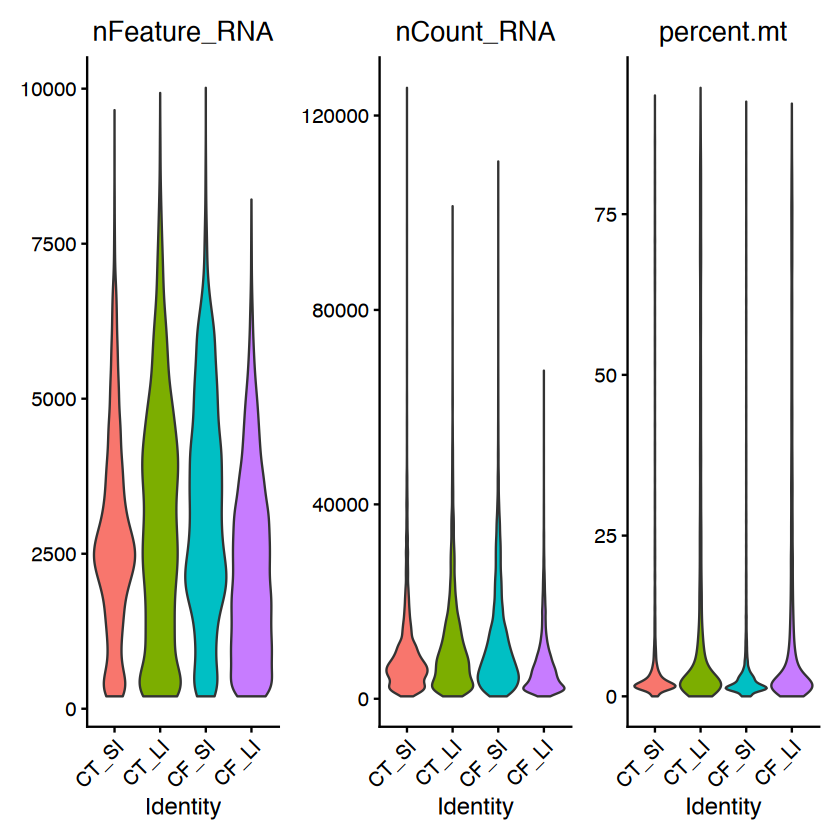

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 84 rows containing non-finite outside the scale range
(`stat_density()`).”


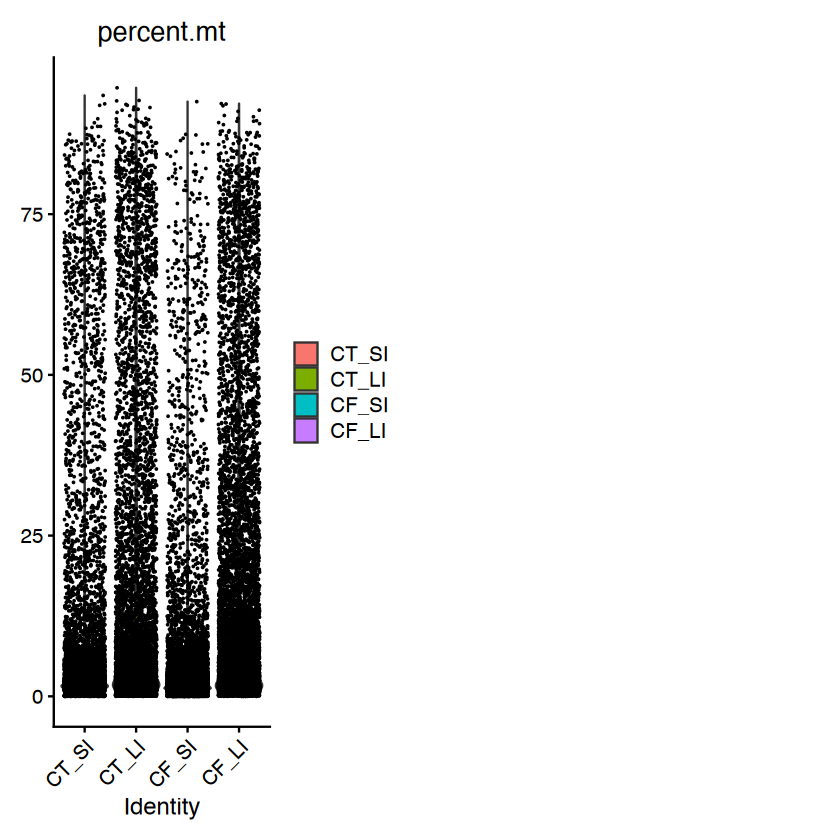

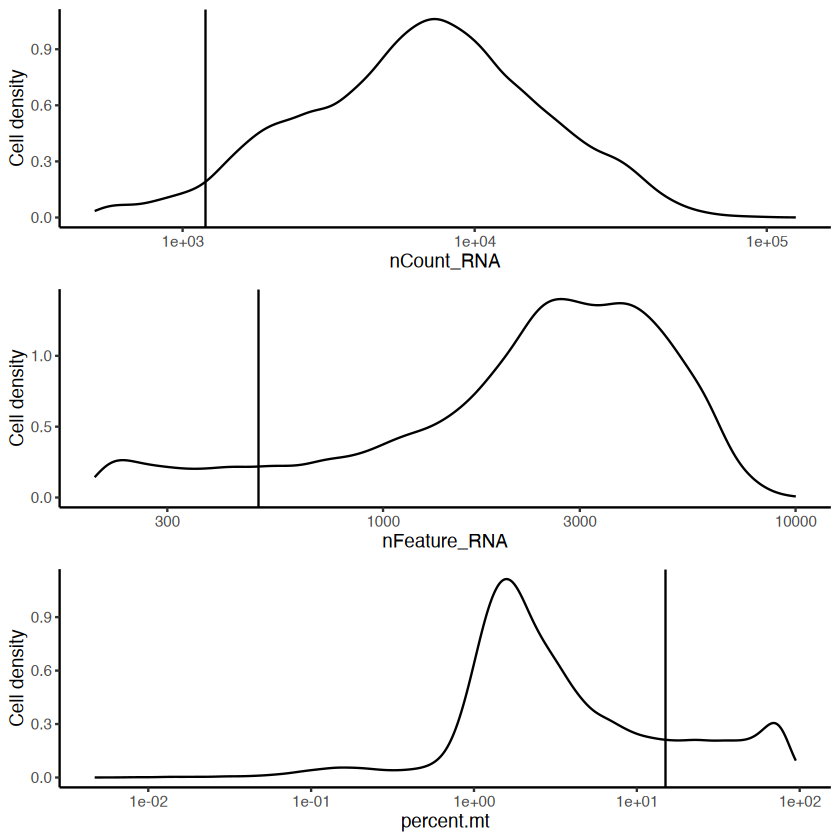

In [ ]:
#Quantifying percentage mitochondria
seurat[["percent.mt"]] <- PercentageFeatureSet(seurat, assay="RNA",pattern = "mt-")

VlnPlot(seurat, features = c("nCount_RNA", "nFeature_RNA", "percent.mt"), ncol=3, pt.size = 0)

# Setting thresholds:
nCount_RNA_threshold <- 1200
nFeature_RNA_threshold <- 500
percent_mt_threshold <- 5

p1 <- seurat@meta.data %>% 
  	ggplot(aes(x=nCount_RNA)) + 
  	geom_density() + 
  	scale_x_log10() + 
  	theme_classic() +
  	ylab("Cell density") +
  	geom_vline(xintercept = nCount_RNA_threshold)

p2 <- seurat@meta.data %>% 
  	ggplot(aes(x=nFeature_RNA)) + 
  	geom_density() + 
  	scale_x_log10() + 
  	theme_classic() +
  	ylab("Cell density") +
  	geom_vline(xintercept = nFeature_RNA_threshold)

p3 <- seurat@meta.data %>% 
  	ggplot(aes(x=percent.mt)) + 
  	geom_density() + 
  	scale_x_log10() + 
  	theme_classic() +
  	ylab("Cell density") +
  	geom_vline(xintercept = percent_mt_threshold)

grid.arrange(p1, p2, p3)    

# # Visualize feature relationships
# # plot1 <- FeatureScatter(seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")

# # plot2 <- FeatureScatter(seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
# # plot1+plot2

cell_number <- list(nrow(seurat[[]]))


In [ ]:
# Filter data

cell_number <- list(nrow(seurat[[]]))
seurat_old <- seurat
seurat <- subset(seurat, subset = nFeature_RNA  > nFeature_RNA_threshold & percent.mt < percent_mt_threshold & nCount_RNA > nCount_RNA_threshold)
cell_number <- append(cell_number, nrow(seurat[[]]))

print("Cell number before and after filterings")
print(cell_number)


:::{.content-visible when-meta='verbose'}
## Data Normalization
:::

In [ ]:
# Normalize RNA data with SCTransform
seurat <- SCTransform(seurat, verbose = T)

# Normalize HTO data with CLR
seurat <- NormalizeData(seurat, assay = "HTO",normalization.method = "CLR")

:::{.content-visible when-meta='processing'}
## Hashtag Demultiplexing
:::

In [ ]:
plot1 <- seurat@meta.data %>% 
  	ggplot(aes(x=nCount_HTO)) + 
  	geom_density() + 
  	scale_x_log10() + 
  	theme_classic() +
  	ylab("Cell density") 

plot2 <- seurat@meta.data %>% 
  	ggplot(aes(x=nFeature_HTO)) + 
  	geom_density() + 
  	scale_x_log10() + 
  	theme_classic() +
  	ylab("Cell density") 

plot1+plot2

:::{.content-visible when-meta='processing'}
### Demultiplexing with HTO Demux
:::

In [ ]:
seurat <- HTODemux(seurat, assay = "HTO", positive.quantile = 0.99)

table(seurat$HTO_classification.global)

#tSNE-visualization
seurat_subset <- subset(seurat, idents = "Negative", invert =TRUE)
DefaultAssay(seurat_subset) <- "HTO"
seurat_subset <- ScaleData(seurat_subset, assay = "HTO",  features = rownames(seurat_subset), verbose = FALSE )
seurat_subset <- RunPCA(seurat_subset, assay = "HTO", rownames(seurat_subset), approx = FALSE)
seurat_subset <- RunTSNE(seurat_subset, assay = "HTO", dims = 1:24, perplexity = 100, check_duplicates=FALSE)
DimPlot(seurat_subset)


In [ ]:
print("Number of Singlets")
print()(nrow(seurat@meta.data |> filter("HTO_classification.global" == 'Singlet')))

print("Number of Doublets")
print(nrow(seurat@meta.data |> filter("HTO_classification.global" == 'Doublet')))

print("Number of Negatives")
print(nrow(seurat@meta.data |> filter("HTO_classification.global" == 'Negative')))


# Filtering singlets only
Idents(seurat) <- "HTO_classification.global"
seurat <-subset(seurat, idents = "Singlet")


:::{.content-visible when-meta='processing'}
### Demultiplexing with Demuxmix
:::

In [ ]:
# Running demuxmix
library(demuxmix)

GetAssayData(seurat, assay = "HTO", layer = "counts")  |> 
  as.matrix() -> hto_counts

demuxmix_results <- demuxmix(hto_counts, rna = seurat@meta.data$nFeature_RNA)


In [ ]:
# Results Summary
summary(demuxmix_results)
classes <- dmmClassify(demuxmix_results)
table(classes$Type)

Class,NumObs,RelFreq,MedProb,ExpFPs,FDR
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Eight,7,0.001546278,0.9235543,0.7730501,0.11043572
Fifteen,437,0.096531920,0.9970710,6.6288040,0.01516889
Fourteen,338,0.074663132,0.9970502,5.0109995,0.01482544
Nine,6,0.001325381,0.9175696,0.8846451,0.14744085
One,412,0.091009499,0.9967330,10.6807806,0.02592422
Sixteen,529,0.116854429,0.9976705,8.5928500,0.01624357
Ten,29,0.006406008,0.9996476,0.4833365,0.01666678
Thirteen,1266,0.279655401,0.9974533,23.2391292,0.01835634
Twelve,774,0.170974155,0.9970046,15.1370360,0.01955689



multiplet  negative   singlet uncertain 
      305       424      3798         3 

In [ ]:
# Integrating with seurat:

seurat$demuxmix_classification <- classes$HTO
seurat$demuxmix_classification_global <- classes$Type

# Visualization of Results:
Idents(seurat) <- 'demuxmix_classification_global'
DefaultAssay(seurat) <- "HTO"
seurat <- ScaleData(seurat, assay = "HTO",  features = rownames(seurat), verbose = FALSE )
seurat <- RunPCA(seurat, assay = "HTO", rownames(seurat), approx = FALSE)
seurat <- RunTSNE(seurat, assay = "HTO", dims = 1:24, perplexity = 100, check_duplicates=FALSE)
DimPlot(seurat)

DefaultAssay(seurat) <- "SCT"

In [ ]:
print("Number of Singlets")
print(nrow(seurat@meta.da()ta |> filter( demuxmix_classification_global  == 'singlet')))

print("Number of Doublets")
print(nrow(seurat@meta.data |> filter( demuxmix_classification_global  == 'multipliet')))

print("Number of Negatives")
print(nrow(seurat@meta.data |> filter( demuxmix_classification_global  == 'negative')))

print("Number of Uncertain")
print(nrow(seurat@meta.data |> filter( demuxmix_classification_global  == 'uncertain')))


# Filtering singlets only
Idents(seurat) <-  'demuxmix_classification_global'
seurat <- subset(seurat, subset = demuxmix_classification_global == "singlet")

:::{.content-visible when-meta='verbose'}
## Create Groups
:::

In [ ]:
seurat@meta.data <- seurat@meta.data |>
    mutate(
        Groups = case_when(
            str_detect(hash.ID, 'SPF-iso') ~ 'SPF isotype',
            str_detect(hash.ID, 'SPF-aCD3') ~ 'SPF aCD3',
            str_detect(hash.ID, 'GF-iso') ~ 'GF isotype',
            str_detect(hash.ID, 'GF-aCD3') ~ 'GF aCD3',
            TRUE ~ 'Other'

    ),
        Samples = hash.ID,
        Condition = case_when(
            str_detect(hash.ID, 'SPF') ~ 'SPF',
            str_detect(hash.ID, 'GF') ~ 'GF',
            TRUE ~ 'Other'
        ),
        Treatment = case_when(
            str_detect(hash.ID, 'iso') ~ 'isotype',
            str_detect(hash.ID, 'aCD3') ~ 'aCD3',
        ) 
        )


seurat@meta.data <- seurat@meta.data |>
    mutate(Groups = factor(Groups,levels = c('SPF isotype', 'GF isotype', 'SPF aCD3', 'GF aCD3'))) |>
    mutate(Samples = factor(Samples,levels = c('SPF-iso-1', 
                                                'SPF-iso-2',
                                                'SPF-iso-3',
                                                'SPF-iso-4',
                                                'SPF-aCD3-1',
                                                'SPF-aCD3-2',
                                                'SPF-aCD3-3',
                                                'GF-iso-1',
                                                'GF-iso-2',
                                                'GF-iso-3',
                                                'GF-iso-4',
                                                'GF-aCD3-1',
                                                'GF-aCD3-2',
                                                'GF-aCD3-3',
                                                'GF-aCD3-4'                                                
                                                ))) 
    
#Create groups
colnames(seurat@meta.data)
levels(seurat$Groups)
levels(seurat$Samples)

:::{.content-visible when-meta='processing'}
## Clustering
:::

In [ ]:
#| fig-cap: 'Elbow plot showing the percentage of variability represented by by each PC to select number of dimensions '

#Dimensionality reduction
seurat <- RunPCA(seurat,npcs = 200
)

#Determining dimensionality of the dataset
ElbowPlot(seurat, ndims = 200)


:::{.content-visible when-meta='processing'}
Chosen Number of Dimensions:
:::

In [ ]:
# Describe number of dimensions

dimensions  <- 45
dimensions


In [ ]:
#| results: hide
seurat <- RunUMAP(seurat, dims=1:dimensions, verbose = F)
resolutions <- c(0.25, 0.375, 0.5, 0.625, 0.75, 1, 1.25, 1.5, 1.75)
seurat <- FindNeighbors(seurat, dims = 1:dimensions, verbose = F)
seurat <- FindClusters(seurat, resolution = resolutions, verbose = F)

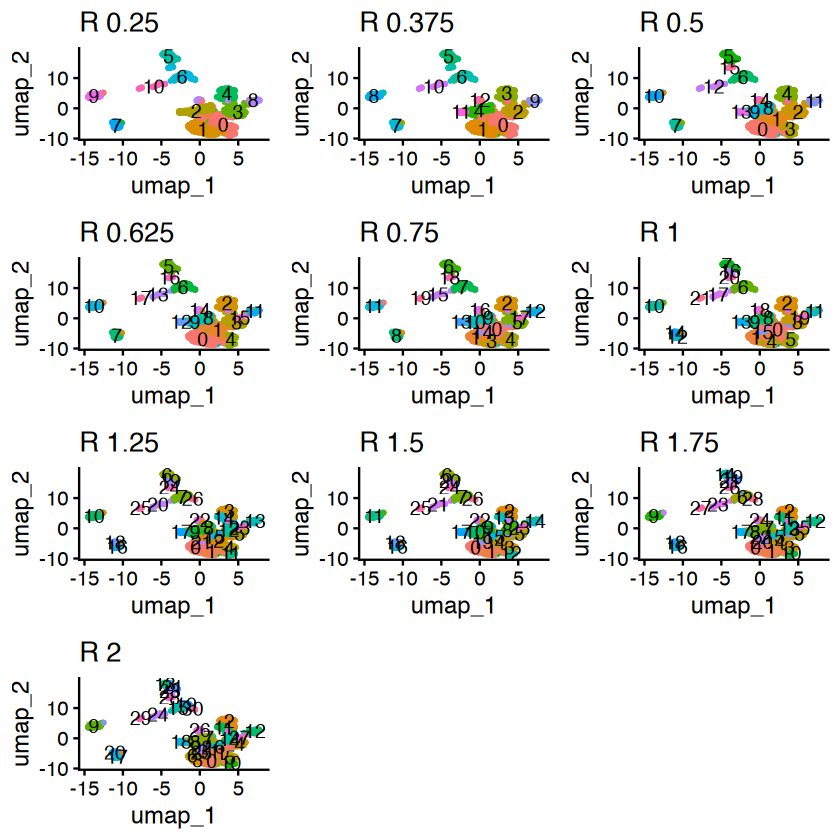

In [ ]:
#| fig-cap: 'UMAP plots showing the clustering results at different resolutions'
#| fig.width: 8
#| fig.height: 8

p <- list()
i <- 1
for (resolution in resolutions ) {
    Idents(seurat) <- paste0('SCT_snn_res.', resolution) 
    p2 <- DimPlot(seurat, reduction = "umap", label = TRUE, label.size = 2.5) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")    
    p[[i]] <- p2
    i <- i+1
}

plot <- grid.arrange(grobs = p)
# ggsave('initial_clustering_results_by_resolution.pdf', path = here('result/figures'), plot = plot)


:::{.content-visible when-meta='processing'}
Chosen resolution
:::

In [ ]:
resolution <- 0.625
resolution


[1] 0.625

:::{.content-visible when-meta='processing'}
## Removing contaminating clusters
:::

:::{.content-visible when-meta='processing'}
### Looking for Outlier Clusters
:::

In [ ]:
Idents(seurat) <- paste0('RNA_snn_res.', resolution)
seurat[['seurat_clusters']]<- Idents(seurat)
DimPlot(seurat, reduction = "umap", label = TRUE) + ggtitle(paste0('R ', resolution))
DimPlot(seurat, reduction = "umap", label = TRUE, split.by = 'Groups', ncol = 3) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")


:::{.content-visible when-meta='verbose'}
### Top DEGs per cluster 
:::

In [ ]:
object_annotations <- 'pre_filtering'
 
Idents(seurat) <- 'seurat_clusters'

seurat.markers <- FindAllMarkers(seurat, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

# saveRDS(seurat.markers, file = 'seurat.markers.rds')



#Add gene annotations:
annotations <- read.csv(here("scripts/annotations.csv"))
seurat.markers <- seurat.markers |>
                left_join(y= unique(annotations[,c('gene_name', 'description')]),
                    by = c('gene' = 'gene_name'))

                    

#Top10 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 10) -> top10

#Top25 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 25) -> top25

#Top100 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 100) -> top100

#Top3 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 3) -> top3

write.table(top100,file=paste0(tables_path,'top100', '_',object_annotations, ".tsv"), sep="\t",row.names = FALSE)
# write.table(top25,file=paste0(path,'top25',object_annotations, ".tsv"), sep="\t",row.names = FALSE)
write.table(top10,file=paste0(tables_path,'top10', '_',object_annotations, ".tsv"), sep="\t",row.names = FALSE)


# # #Top5 markers
# seurat.markers %>%
#     group_by(cluster) %>%
#     slice_head(n = 5) -> top5
# DoHeatmap(seurat, features = top5$gene, size = 1) + NoLegend() & theme(text=element_text(size=6))
# ggsave(paste0("Heatmap_Top5_per_cluster", object_annotations, ".pdf"), path = path)

# #Top10 markers
# seurat.markers %>%
#      group_by(cluster) %>%
#      slice_head(n = 10) -> top10
#  DoHeatmap(seurat, features = top10$gene, size = 1) + NoLegend() & theme(text=element_text(size=4)) 
#  ggsave(paste0("Heatmap_Top10_per_cluster", object_annotations, ".pdf"), path = path)

gene_list_plot <- top3 |> pull(gene)

pdf(paste0(figures_path, 'Top_3_per_cluster_dotplot_', object_annotations, '.pdf'))
Clustered_DotPlot(seurat, features=gene_list_plot, k=length(unique(seurat$seurat_clusters)), plot_km_elbow = FALSE, cluster_ident=FALSE, ggplot_default_colors = T)

dev.off()


    

:::{.content-visible when-meta='processing'}
### Automatic cell type annotations
:::

In [ ]:
local_path <- paste0(results_path,object_annotations,'_cell_type_annotations')
unlink(local_path,recursive = T)
dir.create(local_path)


:::{.content-visible when-meta='processing'}
#### SingleR annotations
:::

In [ ]:
seurat <- NormalizeData(seurat, assay = "RNA",normalization.method = "LogNormalize", scale.factor = 10000)

DefaultAssay(seurat) <- 'RNA'

Normalizing layer: counts



:::{.content-visible when-meta='processing'}
Annotations per Cluster
:::

Warning message:
“Layer ‘scale.data’ is empty”
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

F

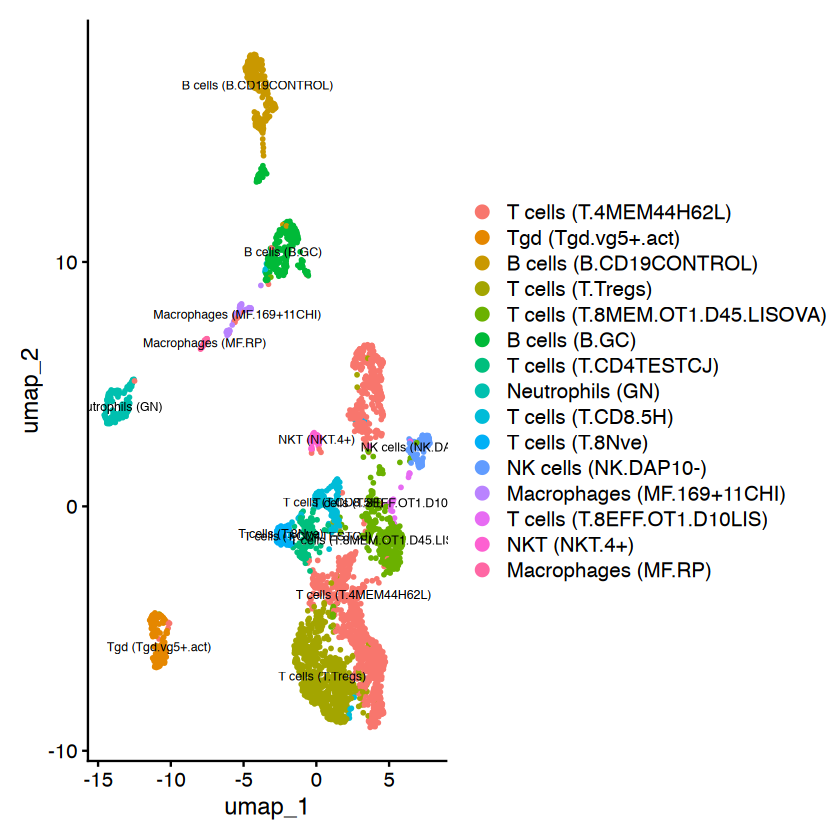

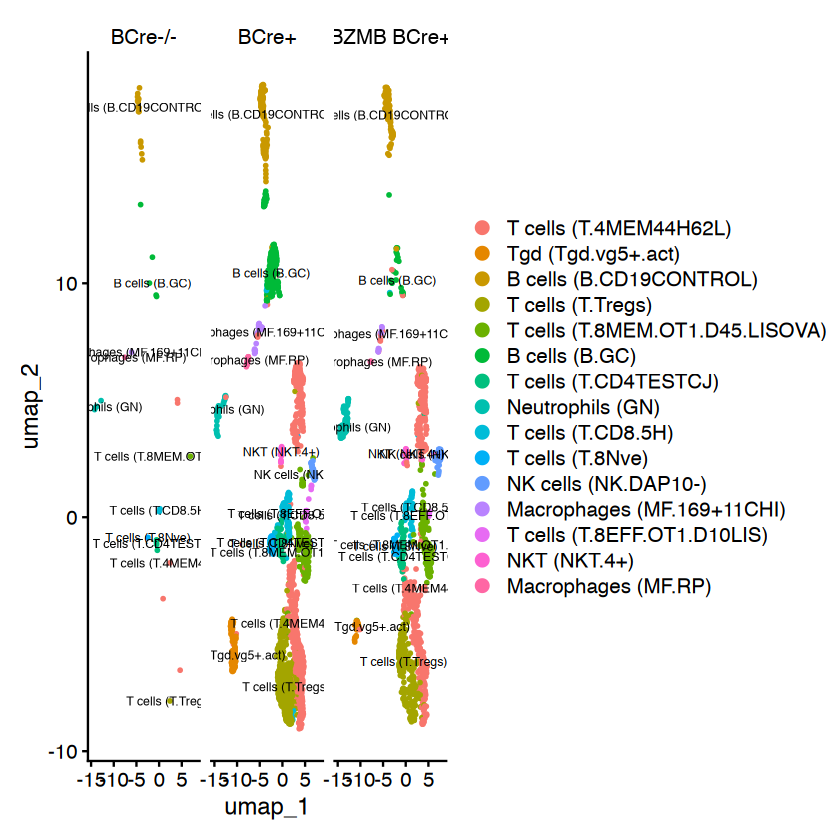

In [ ]:
immgen <- ImmGenData(ensembl = FALSE)
predictions_cluster <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.fine, cluster = seurat$seurat_clusters)

row.names <- rownames(predictions_cluster)

predictions_cluster <- predictions_cluster |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cluster$cluster <- row.names

#predictions_cluster <- predictions_cluster |> rename('labels_per_cluster' = 'labels')

annotations <- seurat@meta.data |>
    left_join(predictions_cluster, by = join_by('seurat_clusters' == 'cluster')) |>
    pull(labels)

seurat$labels_per_cluster <- annotations

Idents(seurat) <- 'labels_per_cluster'
DimPlot(seurat, label = T, label.size = 2.5)
ggsave(paste0('UMAP_cluster_SingleR_annotations','.pdf'), path = local_path, width = 8, height = 5)
p1 <- DimPlot(seurat, label = T, label.size = 2.5, split.by = 'Groups')
ggsave(plot = , paste0('UMAP_cluster_SingleR_annotations_by_group','.pdf'), path = local_path, width = 13, height = 5)


:::{.content-visible when-meta='processing'}
Annotations per Cell
:::

Warning message:
“Layer ‘scale.data’ is empty”
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

F

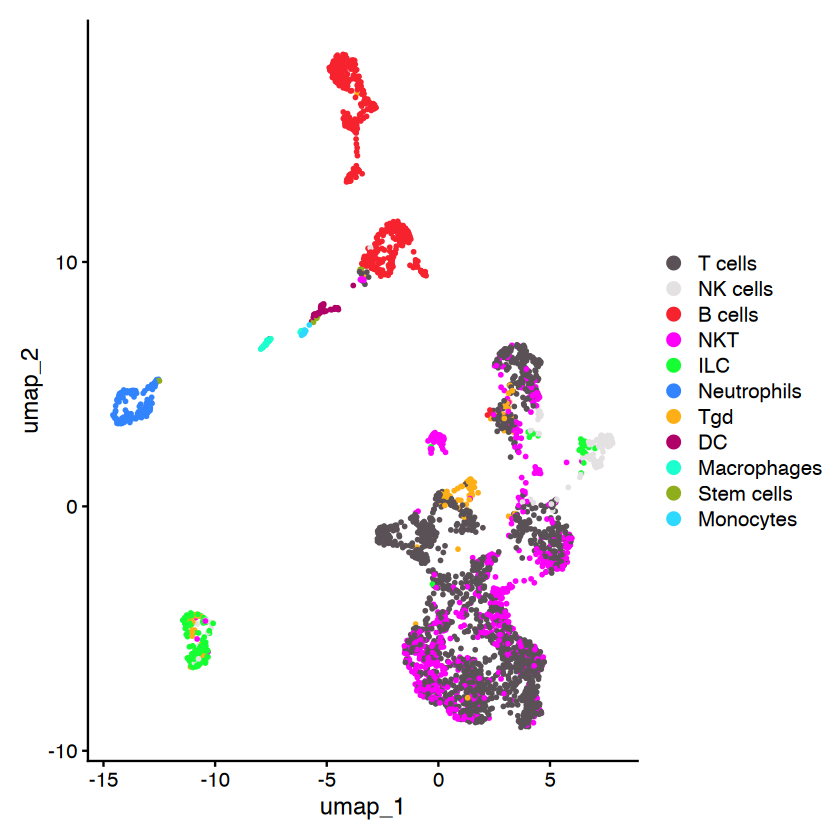

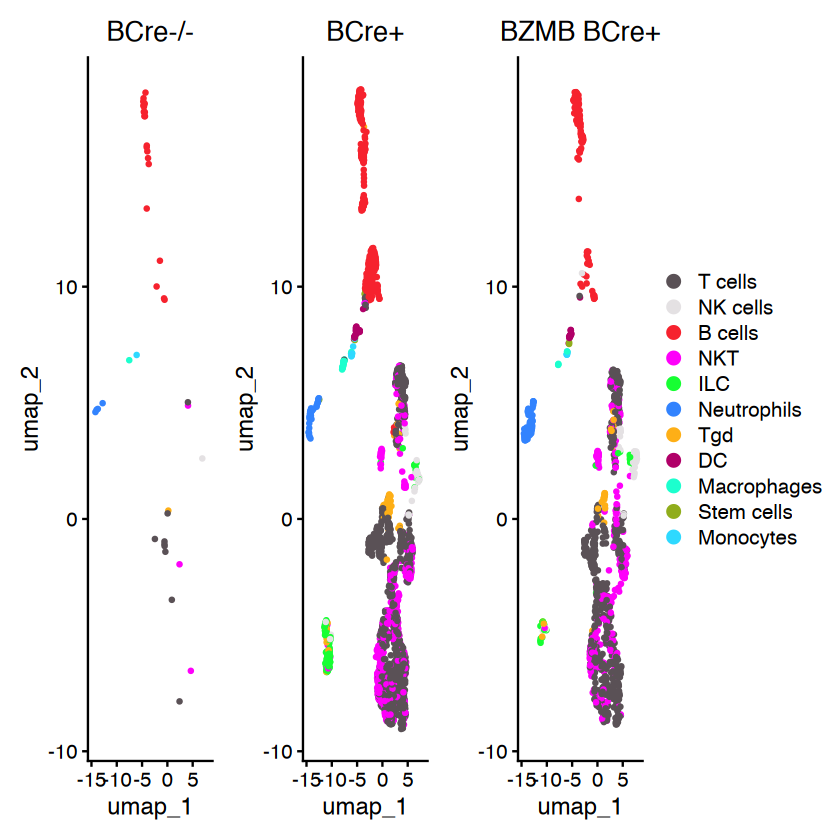

In [ ]:
immgen <- ImmGenData(ensembl = FALSE)
predictions_cell_basis <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.main)

predictions_cell_basis <- predictions_cell_basis |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cell_basis <- predictions_cell_basis |> rename('labels_per_cell_coarse' = 'labels')

seurat$labels_per_cell_coarse <- predictions_cell_basis |> pull(labels_per_cell_coarse)
    
Idents(seurat) <- 'labels_per_cell_coarse'
DimPlot_scCustom(seurat, label = F)#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_coarse','.pdf'), path = local_path, width = 5, height = 5)
p1 <- DimPlot_scCustom(seurat, label = F, split.by = 'Groups')#+ theme(legend.position = 'none')
ggsave(plot = p1, filename = paste0('UMAP_cell_SingleR_annotations_coarse_by_group','.pdf'), path = local_path, width = 13, height = 5)


Warning message:
“Layer ‘scale.data’ is empty”
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

F

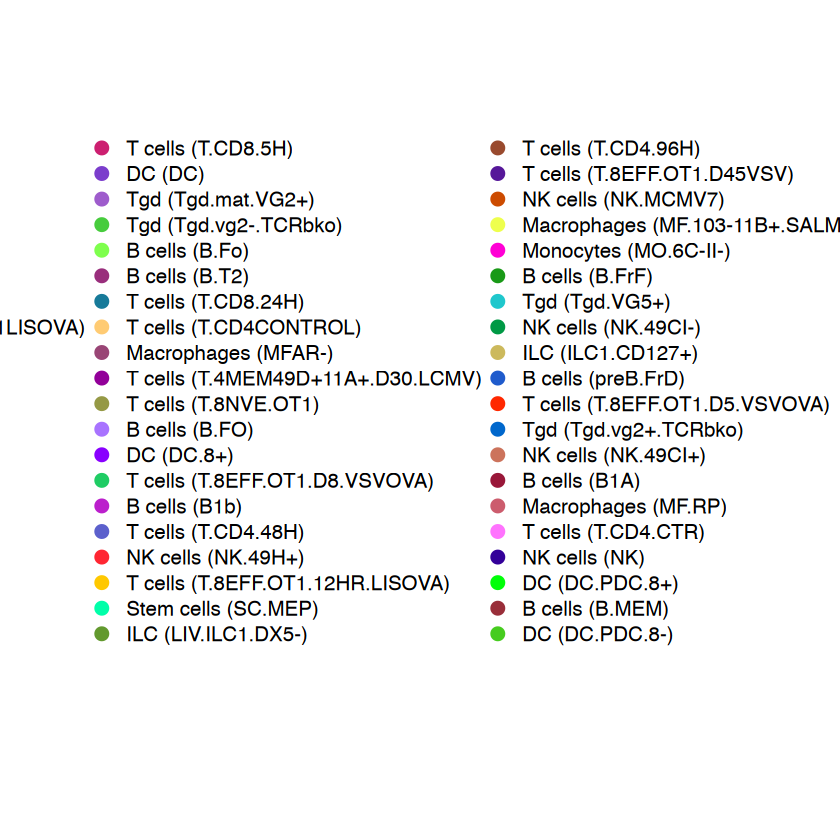

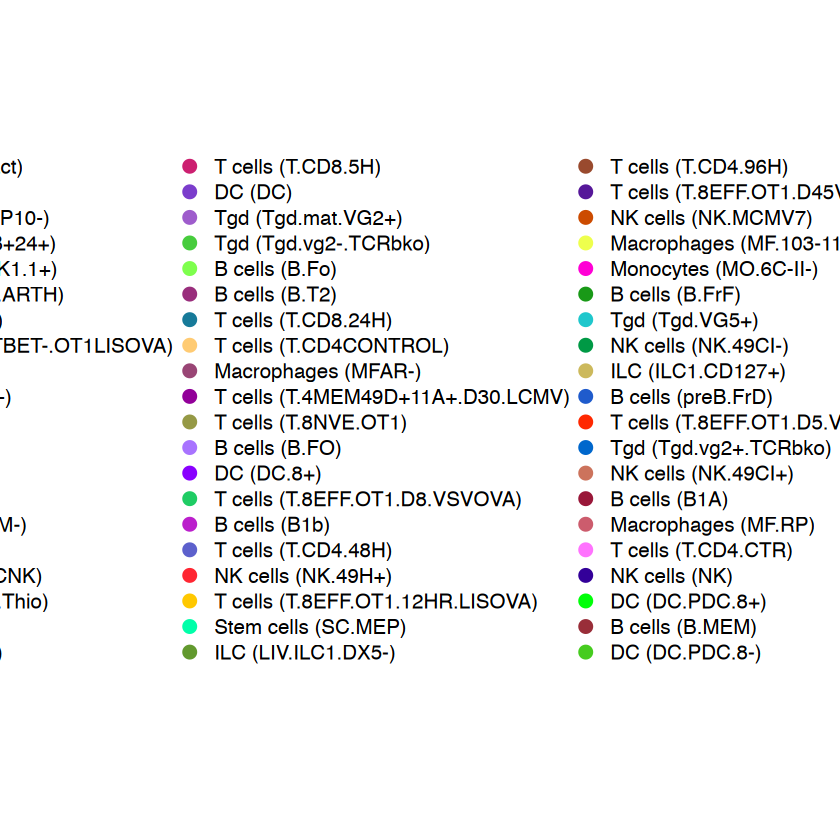

In [ ]:
#| output: hide
immgen <- ImmGenData(ensembl = FALSE)
predictions_cell_basis <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.fine)

predictions_cell_basis <- predictions_cell_basis |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cell_basis <- predictions_cell_basis |> rename('labels_per_cell_fine' = 'labels')

seurat$labels_per_cell_fine <- predictions_cell_basis |> pull(labels_per_cell_fine)
    
Idents(seurat) <- 'labels_per_cell_fine'
DimPlot_scCustom(seurat, label = F)#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_fine','.pdf'), path =local_path, width = 26, height = 5)
DimPlot_scCustom(seurat, label = F, split.by = 'Groups')#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_fine_by_group','.pdf'), path =local_path, width = 30, height = 5)

In [ ]:
DefaultAssay(seurat) <- 'SCT'

:::{.content-visible when-meta='processing'}
#### Annotations With Azimuth
:::

In [ ]:
# library(Azimuth)
# library(SeuratData)

# available_data <- AvailableData()
# available_data[grep("Azimuth", available_data[, 3]), 1:3]

# lastseurat <- RunAzimuth(seurat, reference = 'bonemarrowref',assay = 'SCT', )^

:::{.content-visible when-meta='processing'}
### Plotting individual genes of interest for cluster identification
:::

In [ ]:
FeaturePlot_scCustom(seurat, features = c('Cd4', 'Tbx21', 'Vil1', 'Cd19', 'Cd3e', 'Foxp3', 'Rorc', 'Gata3', 'Trbc1', 'Trbc2', 'Trac'))



:::{.content-visible when-meta='processing'}
### Subsetting 
:::

In [ ]:
Idents(seurat) <- 'seurat_clusters'
seurat <- subset(seurat, idents = c('13', '16', '3', '15', '18'), invert = T)
DimPlot(seurat, label = T)


In [ ]:
saveRDS(seurat, here('data', 'scRNAseq_aCD3.rds'))

:::{.content-visible when-meta='processing'}
## Reclustering
:::

In [ ]:
#| fig-cap: 'Elbow plot showing the percentage of variability represented by by each PC to select number of dimensions '

# Normalize RNA data with SCTransform
seurat <- SCTransform(seurat, verbose = T)

#Dimensionality reduction
seurat <- RunPCA(seurat,npcs = 200
)

#Determining dimensionality of the dataset
ElbowPlot(seurat, ndims = 200)


:::{.content-visible when-meta='processing'}
Chosen Number of Dimensions:
:::

In [ ]:
# Describe number of dimensions

dimensions  <- 45


In [ ]:
#| results: hide
seurat <- RunUMAP(seurat, dims=1:dimensions, verbose = F)
resolutions <- c(0.25, 0.375, 0.5, 0.625, 0.75, 1, 1.25, 1.5, 1.75)
seurat <- FindNeighbors(seurat, dims = 1:dimensions, verbose = F)
seurat <- FindClusters(seurat, resolution = resolutions, verbose = F)

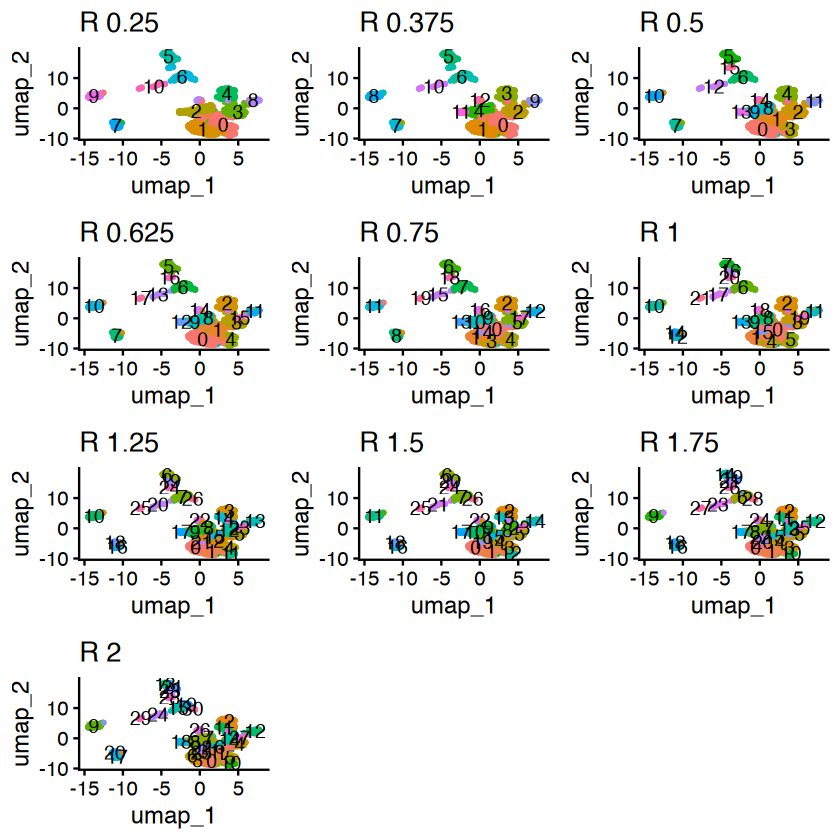

In [ ]:
#| fig-cap: 'UMAP plots showing the clustering results at different resolutions'
#| fig.width: 8
#| fig.height: 8

p <- list()
i <- 1
for (resolution in resolutions ) {
    Idents(seurat) <- paste0('SCT_snn_res.', resolution) 
    p2 <- DimPlot(seurat, reduction = "umap", label = TRUE, label.size = 2.5) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")    
    p[[i]] <- p2
    i <- i+1
}

plot <- grid.arrange(grobs = p)
# ggsave('initial_clustering_results_by_resolution.pdf', path = here('result/figures'), plot = plot)


:::{.content-visible when-meta='processing'}
Chosen resolution
:::

In [ ]:
resolution <- 0.625
resolution


[1] 0.625

# Analysis

## Clustering Results

In [ ]:
Idents(seurat) <- paste0('SCT_snn_res.', resolution)
seurat[['seurat_clusters']]<- Idents(seurat)
DimPlot(seurat, reduction = "umap", label = TRUE) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")
ggsave(paste0('UMAP_clusters_R_', resolution, '.pdf'), path = figures_path)
DimPlot(seurat, reduction = "umap", label = TRUE, split.by = 'Groups', ncol = 2, label.size = 2.5) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")
ggsave(paste0('UMAP_clusters_by_group_R_', resolution, '.pdf'), path = figures_path, width = 5, height = 5)
DimPlot(seurat, reduction = "umap", label = TRUE, split.by = 'Samples', ncol = 4, label.size = 2.5) + ggtitle(paste0('R ', resolution)) + theme(legend.position = "none")
ggsave(paste0('UMAP_clusters_by_sample_R_', resolution, '.pdf'), path = figures_path)

## Cluster Proportions

In [ ]:
#path <- './'
# Extracting cell counts for bar graphs
cell_counts <- FetchData(seurat,vars=c('seurat_clusters', "Samples")) 
cell_counts <- arrange(cell_counts, Samples)


counts <- cell_counts %>% add_count(Samples, name='total_cell_count_by_sample') #%>%  ungroup() %>% arrange( seurat_clusters , desc(hash.ID) ) #%>% arrange('seurat_clusters')

counts <- counts %>% 
    dplyr::count(seurat_clusters, Samples, total_cell_count_by_sample,name='cluster_count')  |> 
        mutate(frequency_within_sample=cluster_count*100/total_cell_count_by_sample)  |> 
        mutate(Samples = as.character(Samples)) |> 

        arrange( Samples, desc(Samples)) #%>% arrange('seurat_clusters')

new_counts <- counts |> 
    arrange(Samples) |>     
    pivot_wider(id_cols = seurat_clusters, names_from = 'Samples', values_from = frequency_within_sample)
    
write.csv(new_counts,file=paste0(tables_path,"number of cells per cluster per condition.csv"),row.names=F)

colors <- c('deeppink', 'deeppink3', 'hotpink', 'hotpink4', 'cadetblue', 'cadetblue2', 'deepskyblue', 'deepskyblue4')
# Barplot of proportion of cells in each cluster by sample
ggplot(seurat@meta.data) +
    geom_bar(aes(x=Groups, fill=seurat_clusters), position=position_fill()) 
ggsave(paste0(figures_path, 'cells_per_cluster_per_group.pdf'))

# Barplot of proportion of cells in each cluster by sample
ggplot(seurat@meta.data) +
    geom_bar(aes(x=Samples, fill=seurat_clusters), position=position_fill())+ theme(axis.text.x = element_text(angle = 45, vjust = 1))
ggsave(paste0(figures_path, 'cells_per_cluster_per_sample.pdf'))
    

## Top DEGs per cluster

In [ ]:
object_annotations <- 'global'
 
Idents(seurat) <- 'seurat_clusters'

seurat.markers <- FindAllMarkers(seurat, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

# saveRDS(seurat.markers, file = 'seurat.markers.rds')



#Add gene annotations:
annotations <- read.csv(here("scripts/annotations.csv"))
seurat.markers <- seurat.markers |>
                left_join(y= unique(annotations[,c('gene_name', 'description')]),
                    by = c('gene' = 'gene_name'))

                    

#Top10 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 10) -> top10

#Top25 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 25) -> top25

#Top100 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 100) -> top100

#Top3 markers
seurat.markers %>%
    group_by(cluster) %>%
    arrange(desc(avg_log2FC)) |>
    slice_head(n = 3) -> top3

write.table(top100,file=paste0(tables_path,'top100', '_',object_annotations, ".tsv"), sep="\t",row.names = FALSE)
# write.table(top25,file=paste0(path,'top25',object_annotations, ".tsv"), sep="\t",row.names = FALSE)
write.table(top10,file=paste0(tables_path,'top10', '_',object_annotations, ".tsv"), sep="\t",row.names = FALSE)


# # #Top5 markers
# seurat.markers %>%
#     group_by(cluster) %>%
#     slice_head(n = 5) -> top5
# DoHeatmap(seurat, features = top5$gene, size = 1) + NoLegend() & theme(text=element_text(size=6))
# ggsave(paste0("Heatmap_Top5_per_cluster", object_annotations, ".pdf"), path = path)

# #Top10 markers
# seurat.markers %>%
#      group_by(cluster) %>%
#      slice_head(n = 10) -> top10
#  DoHeatmap(seurat, features = top10$gene, size = 1) + NoLegend() & theme(text=element_text(size=4)) 
#  ggsave(paste0("Heatmap_Top10_per_cluster", object_annotations, ".pdf"), path = path)

gene_list_plot <- top3 |> pull(gene)

pdf(paste0(figures_path, 'Top_3_per_cluster_dotplot_', object_annotations, '.pdf'))
Clustered_DotPlot(seurat, features=gene_list_plot, k=length(unique(seurat$seurat_clusters)), plot_km_elbow = FALSE, cluster_ident=FALSE, ggplot_default_colors = T)

dev.off()


    

:::{.content-visible when-meta='processing'}
## Automatic cell type annotations
:::

In [ ]:
local_path <- paste0(results_path,object_annotations,'_cell_type_annotations')
unlink(local_path,recursive = T)
dir.create(local_path)


:::{.content-visible when-meta='processing'}
### SingleR annotations
:::

In [ ]:
seurat <- NormalizeData(seurat, assay = "RNA",normalization.method = "LogNormalize", scale.factor = 10000)

DefaultAssay(seurat) <- 'RNA'

Normalizing layer: counts



:::{.content-visible when-meta='processing'}
Annotations per Cluster
:::

Warning message:
“Layer ‘scale.data’ is empty”
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

F

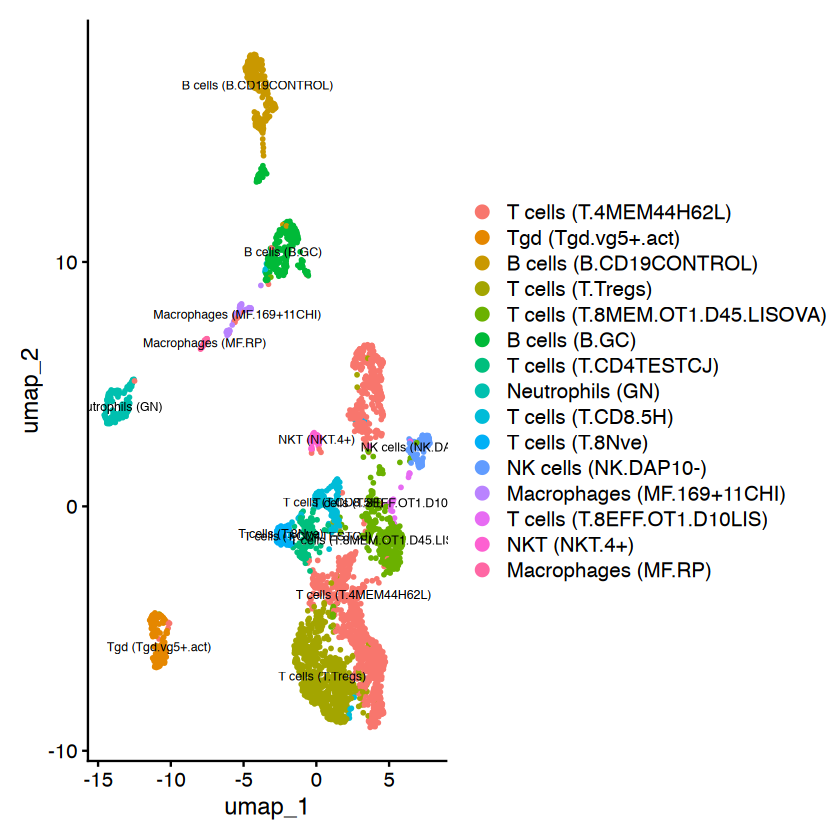

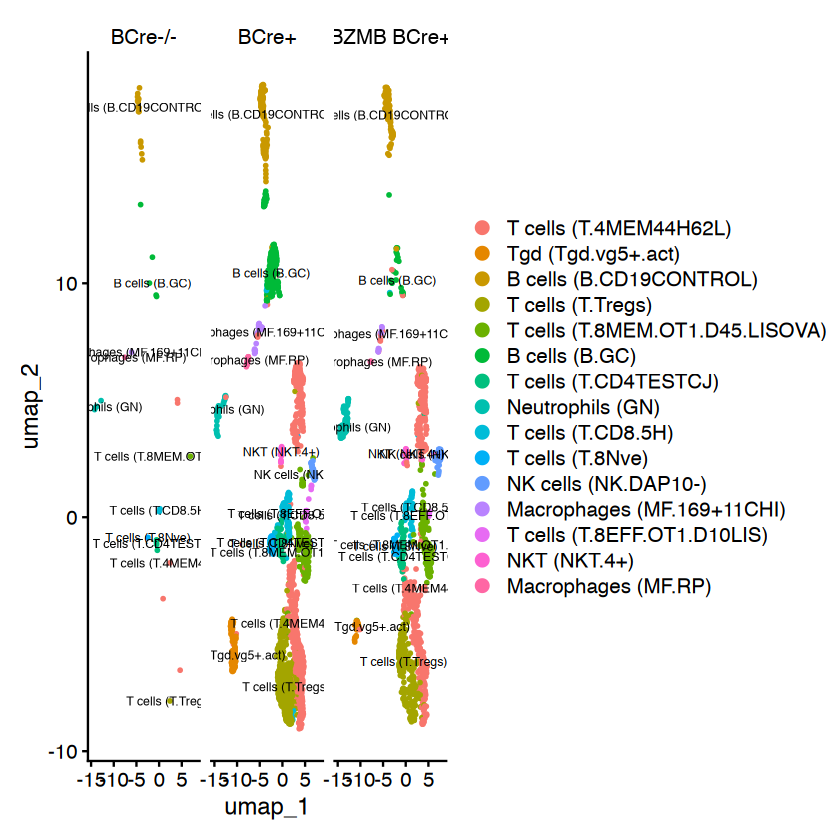

In [ ]:
immgen <- ImmGenData(ensembl = FALSE)
predictions_cluster <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.fine, cluster = seurat$seurat_clusters)

row.names <- rownames(predictions_cluster)

predictions_cluster <- predictions_cluster |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cluster$cluster <- row.names

#predictions_cluster <- predictions_cluster |> rename('labels_per_cluster' = 'labels')

annotations <- seurat@meta.data |>
    left_join(predictions_cluster, by = join_by('seurat_clusters' == 'cluster')) |>
    pull(labels)

seurat$labels_per_cluster <- annotations

Idents(seurat) <- 'labels_per_cluster'
DimPlot(seurat, label = T, label.size = 2.5)
ggsave(paste0('UMAP_cluster_SingleR_annotations','.pdf'), path = local_path, width = 8, height = 5)
p1 <- DimPlot(seurat, label = T, label.size = 2.5, split.by = 'Groups')
ggsave(plot = p1, filename = paste0('UMAP_cluster_SingleR_annotations_by_group','.pdf'), path = local_path, width = 13, height = 5)


:::{.content-visible when-meta='processing'}
Annotations per Cell
:::

Warning message:
“Layer ‘scale.data’ is empty”
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

F

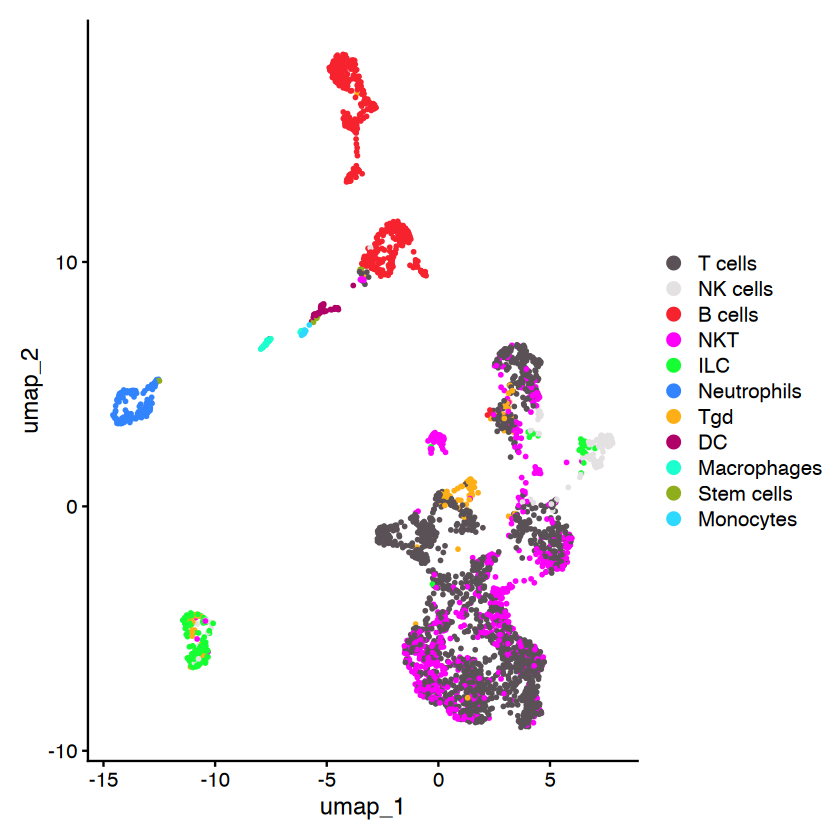

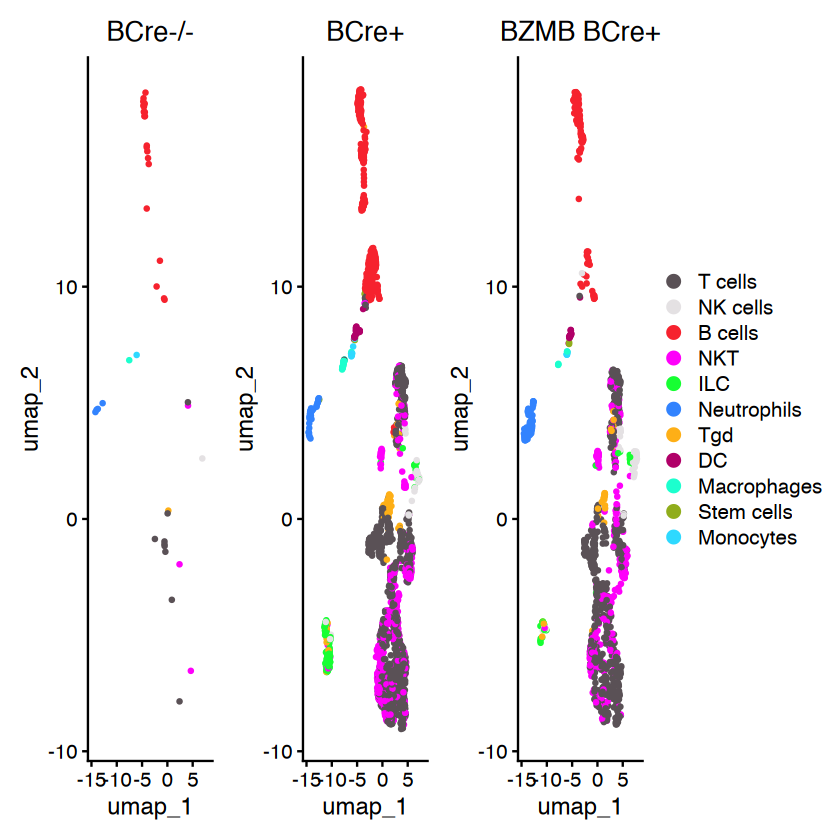

In [ ]:
immgen <- ImmGenData(ensembl = FALSE)
predictions_cell_basis <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.main)

predictions_cell_basis <- predictions_cell_basis |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cell_basis <- predictions_cell_basis |> rename('labels_per_cell_coarse' = 'labels')

seurat$labels_per_cell_coarse <- predictions_cell_basis |> pull(labels_per_cell_coarse)
    
Idents(seurat) <- 'labels_per_cell_coarse'
DimPlot_scCustom(seurat, label = F)#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_coarse','.pdf'), path = local_path, width = 5, height = 5)
p1 <- DimPlot_scCustom(seurat, label = F, split.by = 'Groups')#+ theme(legend.position = 'none')
ggsave(plot = , paste0('UMAP_cell_SingleR_annotations_coarse_by_group','.pdf'), path = local_path, width = 13, height = 5)


Warning message:
“Layer ‘scale.data’ is empty”
Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

Found more than one class "package_version" in cache; using the first, from namespace 'SeuratObject'

Also defined by ‘alabaster.base’

F

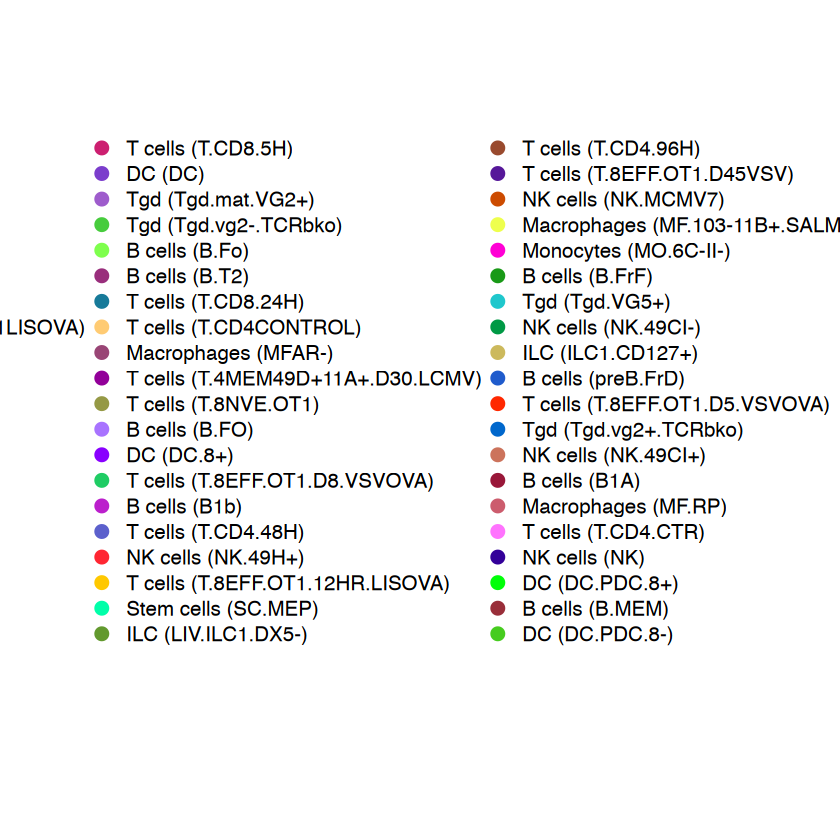

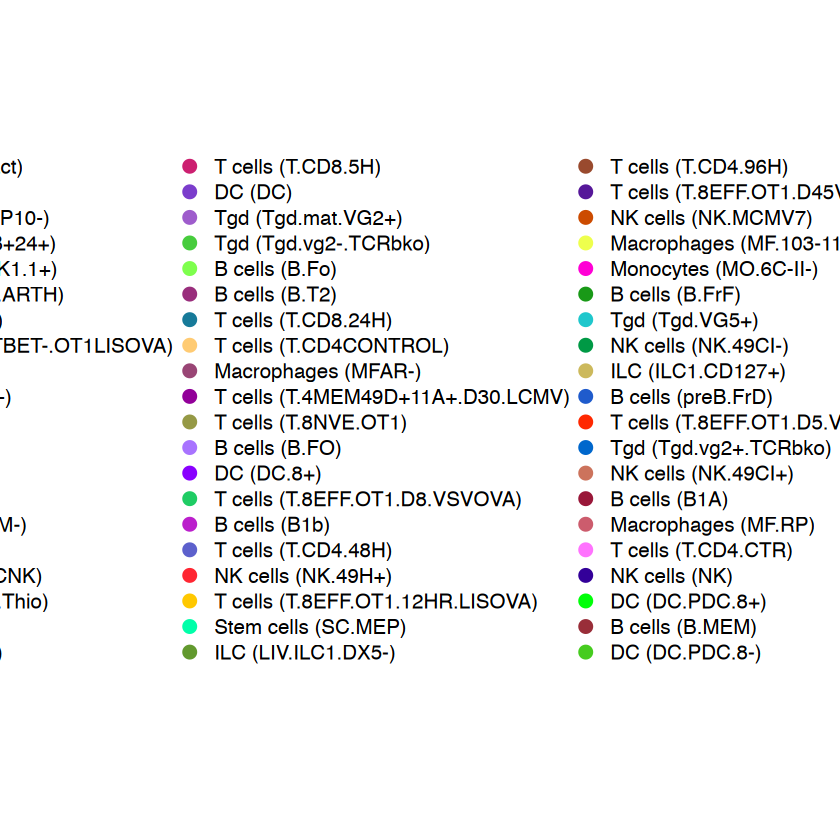

In [ ]:
#| output: hide
immgen <- ImmGenData(ensembl = FALSE)
predictions_cell_basis <- SingleR(test = as.SingleCellExperiment(seurat), assay.type.test = 1, ref = immgen, labels = immgen$label.fine)

predictions_cell_basis <- predictions_cell_basis |>
    as_tibble() |> 
    dplyr::select(c('labels')) 

predictions_cell_basis <- predictions_cell_basis |> rename('labels_per_cell_fine' = 'labels')

seurat$labels_per_cell_fine <- predictions_cell_basis |> pull(labels_per_cell_fine)
    
Idents(seurat) <- 'labels_per_cell_fine'
DimPlot_scCustom(seurat, label = F)#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_fine','.pdf'), path =local_path, width = 26, height = 5)
DimPlot_scCustom(seurat, label = F, split.by = 'Groups')#+ theme(legend.position = 'none')
ggsave(paste0('UMAP_cell_SingleR_annotations_fine_by_group','.pdf'), path =local_path, width = 30, height = 5)

In [ ]:
DefaultAssay(seurat) <- 'SCT'

:::{.content-visible when-meta='processing'}
### Annotations With Azimuth
:::

In [ ]:
# library(Azimuth)
# library(SeuratData)

# available_data <- AvailableData()
# available_data[grep("Azimuth", available_data[, 3]), 1:3]

# lastseurat <- RunAzimuth(seurat, reference = 'bonemarrowref',assay = 'SCT', )^

:::{.content-visible when-meta='verbose'}
## Save Object
:::

In [ ]:
saveRDS(seurat, file = 'scRNAseq_.rds')

## Plotting Genes of Interest

## Annotating clusters

In [ ]:
Idents(seurat) <- 'seurat_clusters'
seurat <- RenameIdents(seurat
    , '0' = 'Tbet+ (Steady state)'  
    , '1' = 'Treg'
    , '2' = 'Tbet+ (In vivo activated)'
    , '3' = 'LN-like'
    , '4' = 'Tbet+ (In vivo activated)'
    , '5' = 'iNKT (Steady state)'
    , '6' = 'Th17 (In vivo activated)'
    , '7' = 'Th17 (Steady state)' 
    , '8' = 'iNKT (In vivo activated)'
    , '9' = 'Proliferating Tregs'
    , '10' = 'LN-like'
    , '11' = 'LN-like'
    , '12' = 'Cycling'
    , '13' = 'ND'
    , '14' = 'Treg'
    , '16' = 'Tbet+ (In vivo activated)'
    , '17' = 'Th17 (Steady state)'
    , '18' = 'ISG'
    , '19' = 'LN-like'
)
seurat[['cell_types']] <- Idents(seurat)

In [ ]:
Idents(seurat) <- 'cell_types'
DimPlot(seurat, label=F, ncol = 2) 
ggsave('UMAP_cell_types.pdf', path = figures_path)

DimPlot(seurat, label=F, split.by = 'Groups', ncol = 2)
ggsave('UMAP_cell_types_by_group.pdf', path = figures_path, width = 8, height = 5)

DimPlot(seurat, label=F, split.by = 'Samples', ncol = 2)
ggsave('UMAP_cell_types_by_sample.pdf', path = figures_path, width = 12, height = 5)


:::{.content-visible when-meta='verbose'}
## Saving object
:::

In [ ]:
saveRDS(seurat, file='scRNAseq_.rds')

## Cell frequency per condition

In [ ]:
#path <- './'
# Extracting cell counts for bar graphs
cell_counts <- FetchData(seurat,vars=c('cell_types', "Samples")) 
cell_counts <- arrange(cell_counts, Samples)


counts <- cell_counts %>% add_count(Samples, name='total_cell_count_by_sample') #%>%  ungroup() %>% arrange( cell_types , desc(hash.ID) ) #%>% arrange('cell_types')

counts <- counts %>% 
    dplyr::count(cell_types, Samples, total_cell_count_by_sample,name='cluster_count')  |> 
        mutate(frequency_within_sample=cluster_count*100/total_cell_count_by_sample)  |> 
        mutate(Samples = as.character(Samples)) |> 

        arrange( Samples, desc(Samples)) #%>% arrange('cell_types')

new_counts <- counts |> 
    arrange(Samples) |>     
    pivot_wider(id_cols = cell_types, names_from = 'Samples', values_from = frequency_within_sample)
    
write.csv(new_counts,file=paste0(tables_path,"number of cells per cluster per condition.csv"),row.names=F)

colors <- c('deeppink', 'deeppink3', 'hotpink', 'hotpink4', 'cadetblue', 'cadetblue2', 'deepskyblue', 'deepskyblue4')
# Barplot of proportion of cells in each cluster by sample
ggplot(seurat@meta.data) +
    geom_bar(aes(x=Groups, fill=cell_types), position=position_fill()) 
ggsave(paste0(figures_path, 'cells_per_cluster_per_group.pdf'))

# Barplot of proportion of cells in each cluster by sample
ggplot(seurat@meta.data) +
    geom_bar(aes(x=Samples, fill=cell_types), position=position_fill())+ theme(axis.text.x = element_text(angle = 45, vjust = 1))
ggsave(paste0(figures_path, 'cells_per_cluster_per_sample.pdf'))
    

# Differential gene expression analysis

## Pseudobulk analysis by condition

In [ ]:
## SPF
genes_of_interest <- list('suppressive signature' = c('Il10', 'Ctla4', 'Tigit', 'Havcr2', 'Gzma', 'Lag3', 'Foxp3'))

path <- paste0(results_path, 'DEG_analysis_SPF_aCD3_vs_isotype/')
unlink(path,recursive = T)
dir.create(path)
Idents(seurat) <- 'cell_types'

DEG_counts <- data.frame(matrix(ncol=3, nrow=0))
colnames(DEG_counts) <- c('DEG_count', 'DEG_UP_count', 'DEG_DOWN_count')
rnames <- c('all_cell_types')

scRNAseq_small <- subset(seurat, subset = Condition == 'SPF')
unique(scRNAseq_small$Samples)

DEG_counts <- pseudobulk(scRNAseq_small, comparison='Samples', group1='iso', group2='aCD3', cluster='all_clusters', path=path, label_threshold = 10000, max_overlaps = 25,gene_lists_to_plot = genes_of_interest, FC_threshold = 1, p_value_threshold = 0.01)

for (x in unique(seurat$cell_types_coarse)) {
    scRNAseq1 <- subset(scRNAseq_small, subset = cell_types_coarse == x )
    counts <- pseudobulk(scRNAseq1, comparison='Samples', group1='iso', group2='aCD3', cluster= x , path=path, label_threshold = 10000, max_overlaps = 25,gene_lists_to_plot = genes_of_interest, FC_threshold = 1,p_value_threshold = 0.01)
    DEG_counts <- rbind(DEG_counts, counts)
    rnames <- c(rnames, x)
}